In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
import collections

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr




In [2]:
#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512]
num_epochs = 50 #20
batch_size = 200
learning_rate = 2e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
norm_layer = None #norm_layer = 'BN'
print(hidden_size)


Using device: cuda
[128, 512, 512, 512, 512]


In [3]:
#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
#################################################################################
# TODO: Q3.a Choose the right data augmentation transforms with the right       #
# hyper-parameters and put them in the data_aug_transforms variable             #
#################################################################################
data_aug_transforms = []
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


data_aug_transforms.append(torchvision.transforms.RandomCrop(size=25))
data_aug_transforms.append(torchvision.transforms.ColorJitter(brightness=(0.3,0.7),contrast=(0.4,0.6)))
data_aug_transforms.append(torchvision.transforms.RandomGrayscale(p=0.2))
data_aug_transforms.append(torchvision.transforms.RandomAffine(degrees=(10,50),translate=(0.1,0.4),scale=(0.1,0.5)))

                           

                    



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=test_transform
                                          )

#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)



Files already downloaded and verified


In [4]:
#-------------------------------------------------
# Convolutional neural network (Q1.a and Q2.a)
# Set norm_layer for different networks whether using batch normalization
#-------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(ConvNet, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the convolutional layer    #
        # described in the exercise.                                                    #
        # For Q1.a make use of conv2d and relu layers from the torch.nn module.         #
        # For Q2.a make use of BatchNorm2d layer from the torch.nn module.              #
        # For Q3.b Use Dropout layer from the torch.nn module.                          #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        layers_dict = collections.OrderedDict()

        # input block 1
        layers_dict['conv_1'] = nn.Conv2d(input_size, hidden_layers[0],\
                                      kernel_size=3, stride=1, padding=1,bias=True)
        if norm_layer=='BN':
            layers_dict['batch_norm1']=nn.BatchNorm2d(hidden_layers[0])
        layers_dict['maxpool_1'] = nn.MaxPool2d(kernel_size=2, stride=2)
        layers_dict['act_1'] = nn.ReLU(inplace=True)
        # convolutional blocks 2-5
        for i in range(1,len(hidden_layers)):
            layers_dict['conv_'+str(i+1)] = \
            nn.Conv2d(hidden_layers[i-1], hidden_layers[i], kernel_size=3, stride=1, padding=1,bias=True)
            if norm_layer=='BN':
                layers_dict['batch_norm'+str(i+1)]=nn.BatchNorm2d(hidden_layers[i])
            layers_dict['maxpool_'+str(i+1)] = nn.MaxPool2d(kernel_size=2, stride=2)
            layers_dict['act_'+str(i+1)] = nn.ReLU(inplace=True)

        layers_dict['conv_flat'] = nn.Flatten() 
        layers_dict['lin_output'] = nn.Linear(hidden_layers[-1], num_classes, bias=True)

        layers = list(layers_dict.values())
        #print(layers)
        self.layers = nn.Sequential(*layers)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        out = self.layers(x)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out


In [5]:
#-------------------------------------------------
# Calculate the model size (Q1.b)
# if disp is true, print the model parameters, otherwise, only return the number of parameters.
#-------------------------------------------------
def PrintModelSize(model, disp=True):
    #################################################################################
    # TODO: Implement the function to count the number of trainable parameters in   #
    # the input model. This useful to track the capacity of the model you are       #
    # training                                                                      #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    

    model_sz=sum(p.numel() for p in model.parameters() if p.requires_grad)
    if disp==True:
        print('total number of parameters of the network is: '+str(model_sz))




    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return model_sz


In [17]:
#-------------------------------------------------
# Calculate the model size (Q1.c)
# visualize the convolution filters of the first convolution layer of the input model
#-------------------------------------------------
def VisualizeFilter(model):
    #################################################################################
    # TODO: Implement the functiont to visualize the weights in the first conv layer#
    # in the model. Visualize them as a single image of stacked filters.            #
    # You can use matlplotlib.imshow to visualize an image in python                #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [18]:
#======================================================================================
# Q1.a: Implementing convolutional neural net in PyTorch
#======================================================================================
# In this question we will implement a convolutional neural networks using the PyTorch
# library.  Please complete the code for the ConvNet class evaluating the model
#--------------------------------------------------------------------------------------
model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer).to(device)
# Q2.a - Initialize the model with correct batch norm layer

model.apply(weights_init)
# Print the model
print(model)
# Print model size
#======================================================================================
# Q1.b: Implementing the function to count the number of trainable parameters in the model
#======================================================================================
PrintModelSize(model)
#======================================================================================

ConvNet(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
    (9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU(inplace=True)
    (15): Flatten()

7678474

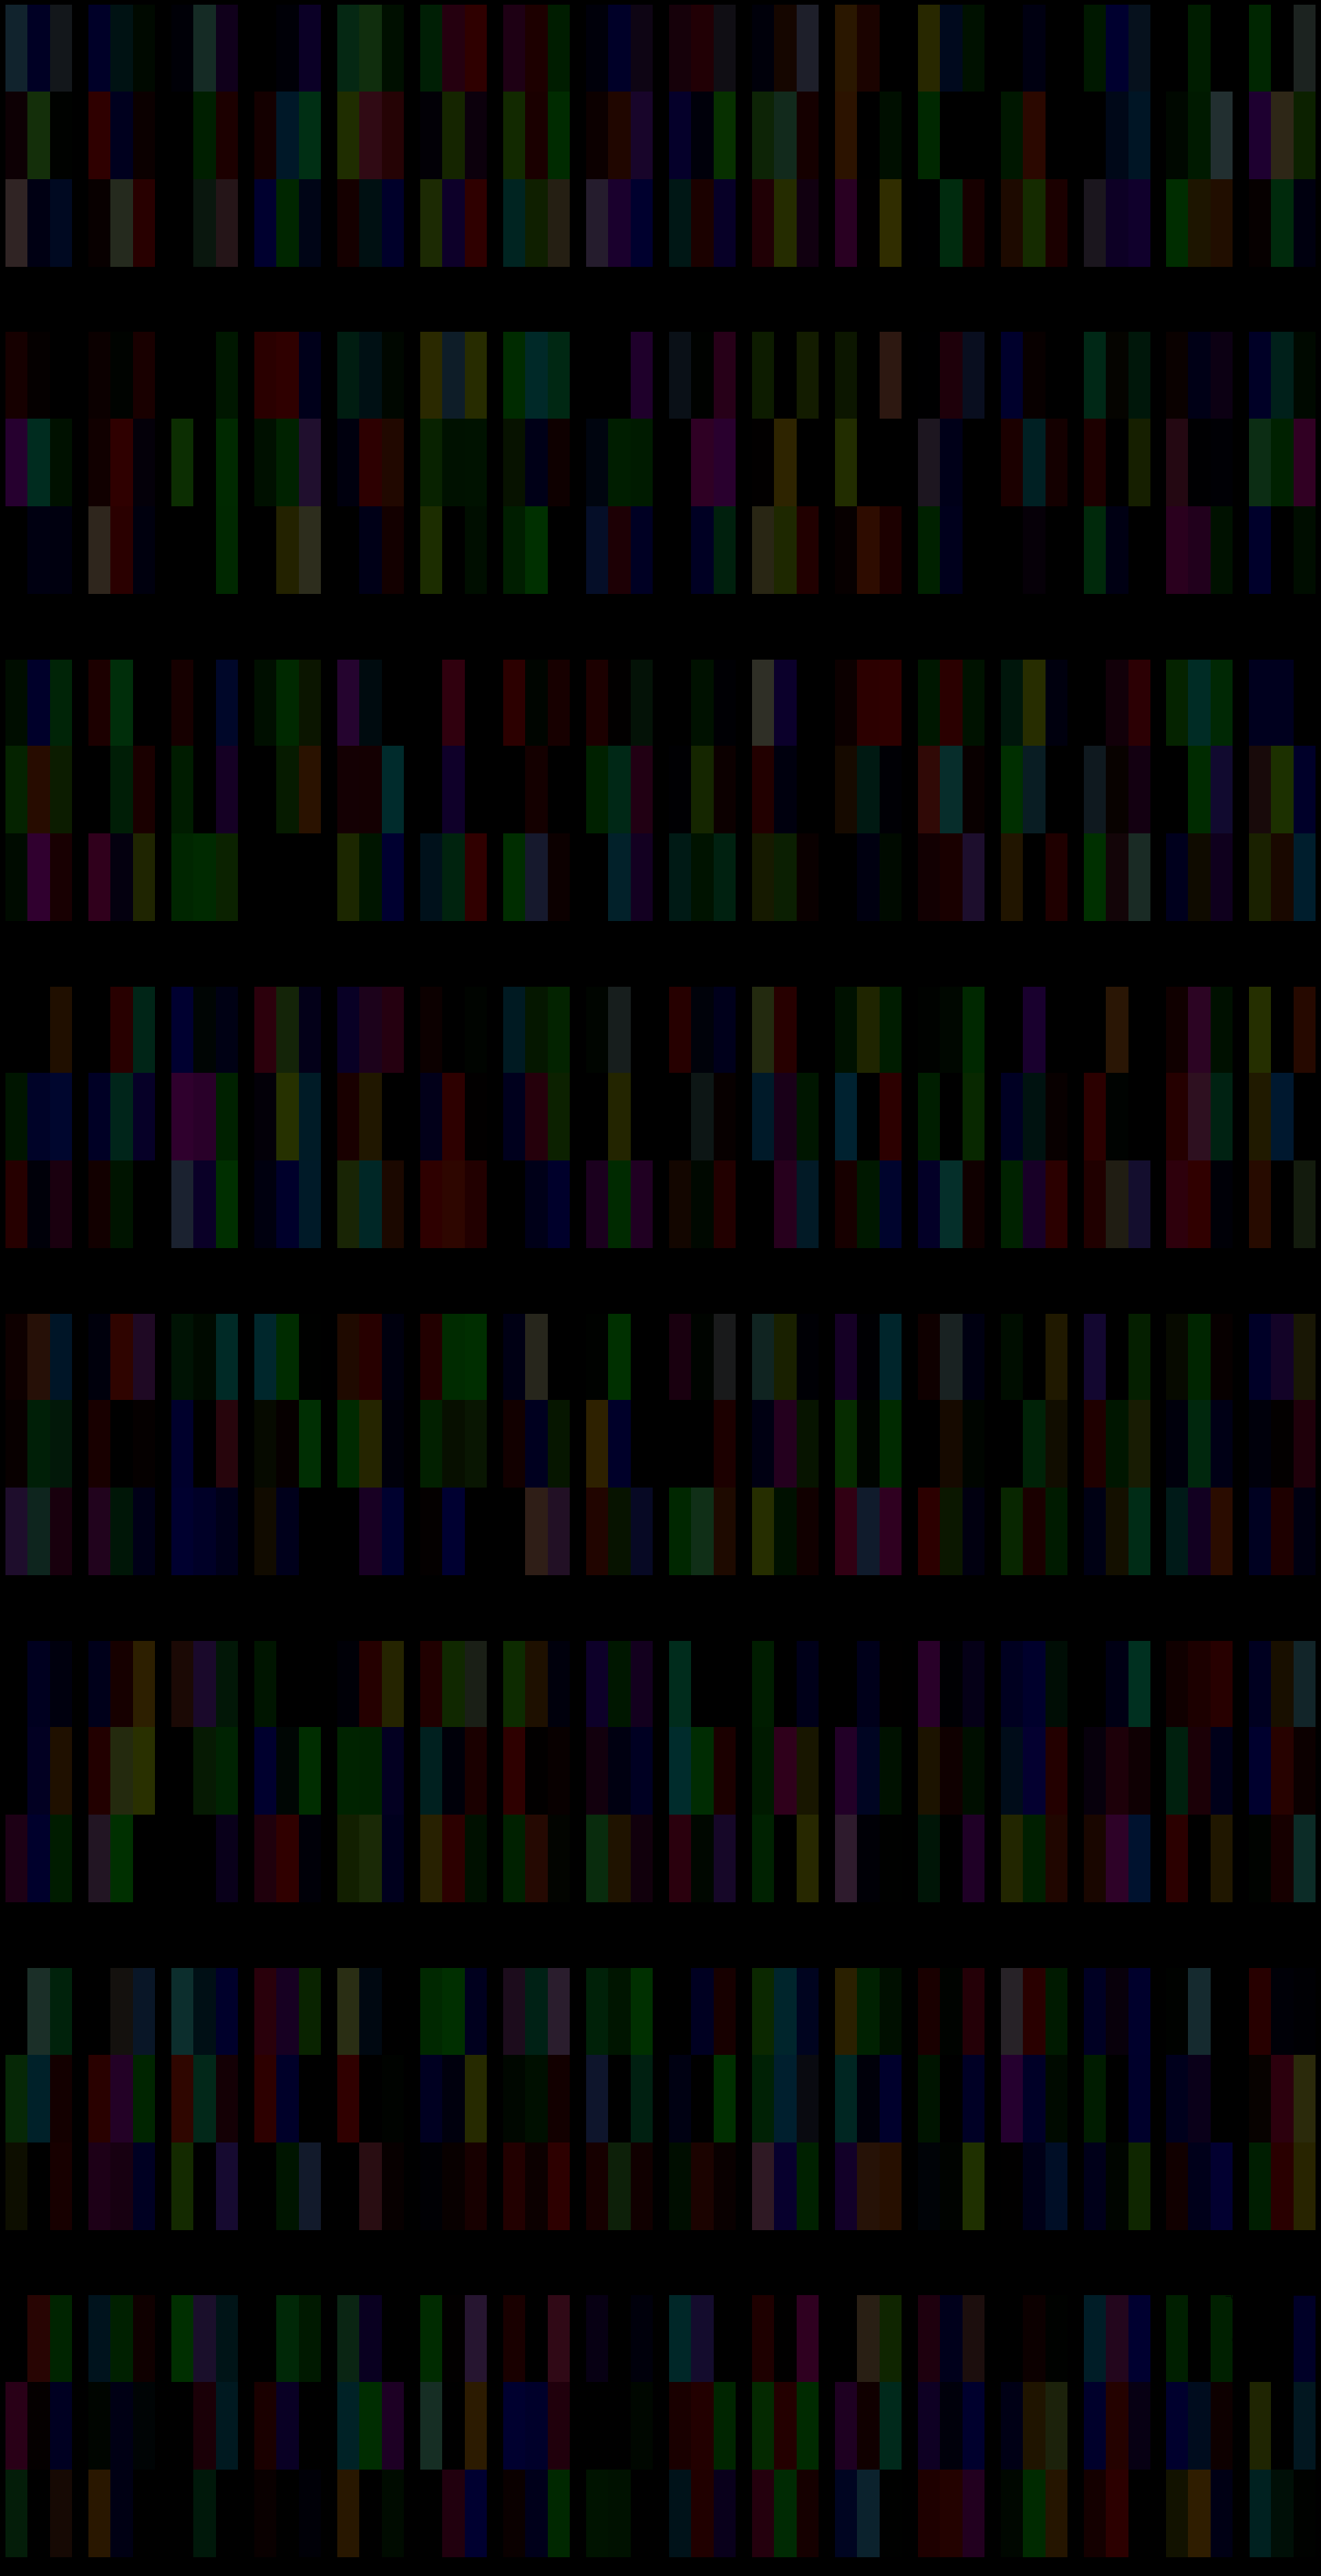

In [21]:
import logging

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

# plotting code here,it will give multiple logs that its clipping input data to [0,255]to match RGB pictures
fig = plt.figure(figsize=(30, 60),facecolor='black')

for n,layer in enumerate(model.layers):
    if n==0:
        layer_weights= layer.weight.data.cpu().numpy()
        for number,i in enumerate(layer_weights):
            fig.add_subplot(8,16,number+1)
            #fig.yticks([0,10,20,30,40,50,60])

            plt.imshow(i)
            plt.axis('off')
            plt.axis("tight")
            #plt.axis("image") 
            
        fig.subplots_adjust(wspace=0.25, hspace=0.25)
        plt.show()

logger.setLevel(old_level)

In [6]:
#======================================================================================
# Q2.a: Implementing convolutional neural net in PyTorch
#======================================================================================
# In this question we will implement a convolutional neural networks using the PyTorch
# library.  Please complete the code for the ConvNet class evaluating the model
#--------------------------------------------------------------------------------------
model = ConvNet(input_size, hidden_size, num_classes, norm_layer='BN').to(device)
# Q2.a - Initialize the model with correct batch norm layer

model.apply(weights_init)
# Print the model
print(model)
# Print model size
#======================================================================================
# Q1.b: Implementing the function to count the number of trainable parameters in the model
#======================================================================================
PrintModelSize(model)
#======================================================================================

ConvNet(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU(inplace=True)
    (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, 

7682826

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []
#best_model = type(model)(input_size, hidden_size, num_classes, norm_layer=norm_layer) # get a new instance
#best_model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer)

not_improving_epochs=0 # i guesss i can put this line here,for the early stopping part of the code,right??
for epoch in range(num_epochs):

    model.train()

    loss_iter = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_iter += loss.item()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    loss_train.append(loss_iter/(len(train_loader)*batch_size))

    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
        
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
        
        loss_val.append(loss_iter/(len(val_loader)*batch_size))

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)
        print('Validation accuracy is: {} %'.format(accuracy))
        
        
        
        
        
        
        #################################################################################
#################################################################################
        # TODO: Q2.b Implement the early stopping mechanism to save the model which has #
        # the model with the best validation accuracy so-far (use best_model).          #
        #################################################################################

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        patience=4
        early_stop=False

        if epoch>patience-1:
            for j in range(patience-1):
                if max(accuracy_val)>list(reversed(accuracy_val))[j]:
                    not_improving_epochs+=1
                    print('validation accuracy didnt improve at epoch: '+str(epoch+1))
                else:
                    not_improving_epochs=0
                    break
                if not_improving_epochs>=patience:
                    early_stop=True
                    print('early stopping clause activated')
                    break
                break
        if early_stop==True:
            print('about to stop')
            break
       

        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()



plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Val loss')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(accuracy_val, 'r', label='Val accuracy')
plt.legend()
plt.show()




RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small